In [1]:
import numpy as np
import matplotlib.pyplot as plt
import aopy
import os
import pandas as pds
from db import dbfunctions as db
from ipywidgets import interactive, widgets
import scipy
import h5py
from tqdm.auto import tqdm 
import seaborn as sn
import sklearn
from sklearn.decomposition import PCA, FactorAnalysis
from itertools import compress
import multiprocessing as mp
import time
import math
from scipy.fft import fft
import glob
from datetime import date

In [2]:
# Paths
data_path_preproc = '/media/moor-data/preprocessed.new/'
kilosort_dir = '/media/moor-data/preprocessed/kilosort'
base_save_dir = "/media/moor-data/results/Ryan/neuropixel_targeting/"
save_dir = "/media/moor-data/results/Ryan/neuropixel_targeting/np_analysis_preproc_data"
np_preproc_data_folder = 'np_analysis_preproc_data'
ecog_dec_acc_file_name = 'npinsert_ecog_decoding_all'

subject = 'beignet'
align_events = ['TARGET ONSET', 'GO CUE', 'MOVEMENT ONSET']

In [3]:
good_unit_labels = {}

### Quality metric parameters ###
# 1. Presence Ratio
epoch_size = 10 # [s]
min_trial_prop = 0.9 # presence ratio threshold to classify a unit as a good unit

# 2. Firing Rate
fr_trial_window_size=17

# 3. ISI violations
min_refractory_period = 1 # [ms]
isi_perc_thresh = 0.02
isi_count_thresh = 100

# Load data

## Load preprocessed data to run quality metrics on

In [5]:
start = time.time()
aopy.utils.release_memory_limit()
df, rasters, preproc_metadata = aopy.data.base.pkl_read(f"{subject}_np_preprocessed", os.path.join(base_save_dir, np_preproc_data_folder))
print(f"{np.round((time.time()-start)/60)} min to load preprocessed data")
nrecs = preproc_metadata['nrecs']
recording_site = preproc_metadata['recording_sites'] # will be the same for all align events
implants = ['NPinsert72' if preproc_metadata['implant'][irec] == 'NP_Insert72' else 'NPinsert137' for irec in range(len(preproc_metadata['implant']))] #Rename because name in bmi3d is slightly different (TODO)
dates = np.unique(df['date'])

8.0 min to load preprocessed data


## Load kilosort drift traces

In [6]:
print(recording_site)
# recording_site[2]=47
# recording_site[1] = 73

[ 11  30  56   9  47  40  18  11   9 121  22   9 120  98  45]


  0%|          | 0/15 [00:00<?, ?it/s]

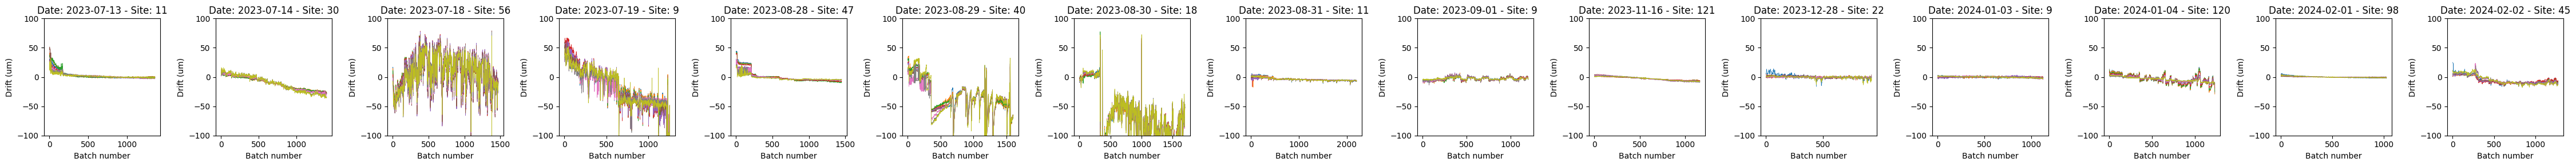

In [7]:
fig, ax = plt.subplots(1, len(dates), figsize=(len(dates)*3, 3))

ks_drift = []
for idate, date in enumerate(tqdm(dates)):
    try:
        concat_data_dir = f'{date}_Neuropixel_ks_{subject}_bottom_port1'
        dshift = aopy.data.load_ks_output(kilosort_dir, concat_data_dir, flag='rez')['dshift']
    except:
        concat_data_dir = f'{date}_Neuropixel_ks_{subject}_site{recording_site[idate]}_bottom_port1'
        dshift = aopy.data.load_ks_output(kilosort_dir, concat_data_dir, flag='rez')['dshift']

    ks_drift.append(np.array(dshift))
    ax[idate].plot(np.array(dshift).T, linewidth=0.5)
    ax[idate].set(xlabel='Batch number', ylabel='Drift (um)', title=f"Date: {date} - Site: {recording_site[idate]}", ylim=(-100, 100))
fig.tight_layout()
plt.show()
drift = {'ks_drift': ks_drift}

In [8]:
drift['drift_max'] = [np.abs(np.max(ks_drift[idate]) - np.min(ks_drift[idate])) for idate in range(len(dates))]
drift['drift_timevar'] = [np.var(np.mean(ks_drift[idate], axis=0)) for idate in range(len(dates))]
drift['drift_depthvar'] = [np.mean(np.var(ks_drift[idate], axis=0)) for idate in range(len(dates))]

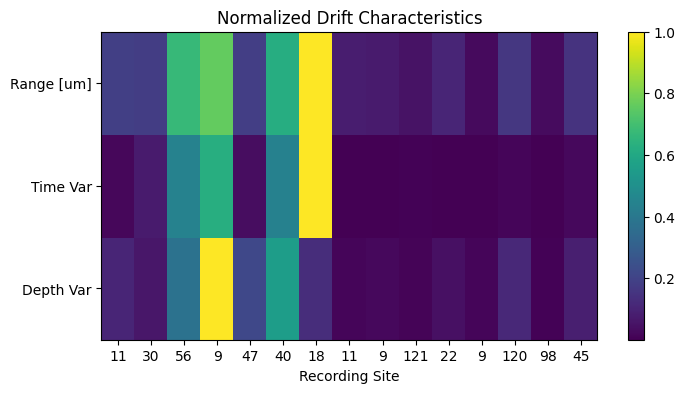

In [9]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
dmap = ax.pcolor(np.array([drift['drift_depthvar']/np.max(drift['drift_depthvar']), drift['drift_timevar']/np.max(drift['drift_timevar']), drift['drift_max']/np.max(drift['drift_max']) ]))
ax.set_xticks(np.arange(len(dates))+0.5, labels=recording_site)
ax.set_yticks(np.arange(3)+0.5, labels=['Depth Var', 'Time Var', 'Range [um]'])
ax.set(xlabel="Recording Site", title='Normalized Drift Characteristics')
cb = plt.colorbar(dmap)

plt.show()

# Apply individual QC metrics to units that are loaded

https://github.com/AllenInstitute/ecephys_spike_sorting/blob/master/ecephys_spike_sorting/modules/quality_metrics/README.md

In [10]:
quality_metrics = {}

## Presence Ratio

In [11]:
def calc_presence_ratio(data, min_trial_prop=0.9, return_details=False):
    '''
    Find which units are active on a high proportion of trials.
    
    Args:
        data (ntime, ntrials, nunit):
        min_trial_prop (float): proportion of trials a unit must have a spike on 
        
    Returns:
        presence_ratio (nunit): Proportion of trials that have a spike for each unit
        present_units (nunit): Binary mask if a unit is present or not
        presence_details (ntrials, nunit): Optional if 'return_details=True' Identifies which trials each unit is active on 
    '''        
    _, ntrials, _ = data.shape
    
    present_trials = np.sum(np.max(data>0, axis=0), axis=0) # Number of trials with a spike for each unit
    
    presence_ratio = (present_trials/ntrials)
    if return_details:
        return presence_ratio, presence_ratio>min_trial_prop, np.max(data>0, axis=0)
    else:
        return presence_ratio, presence_ratio>min_trial_prop

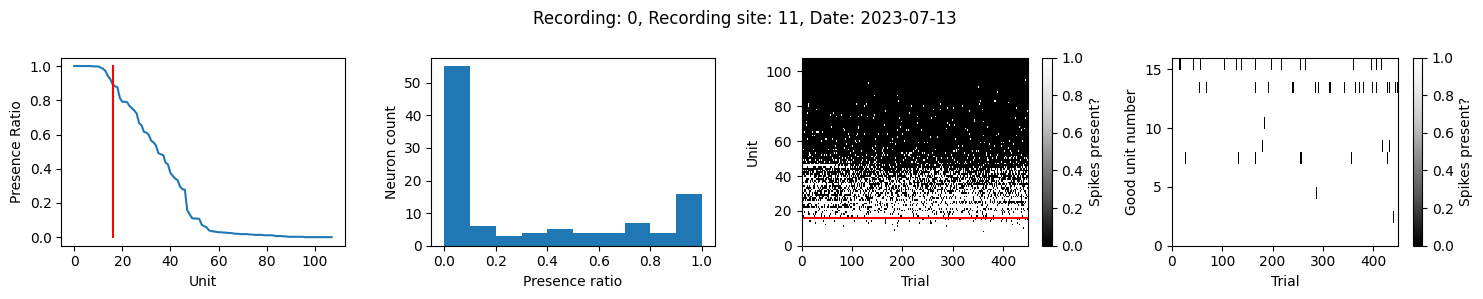

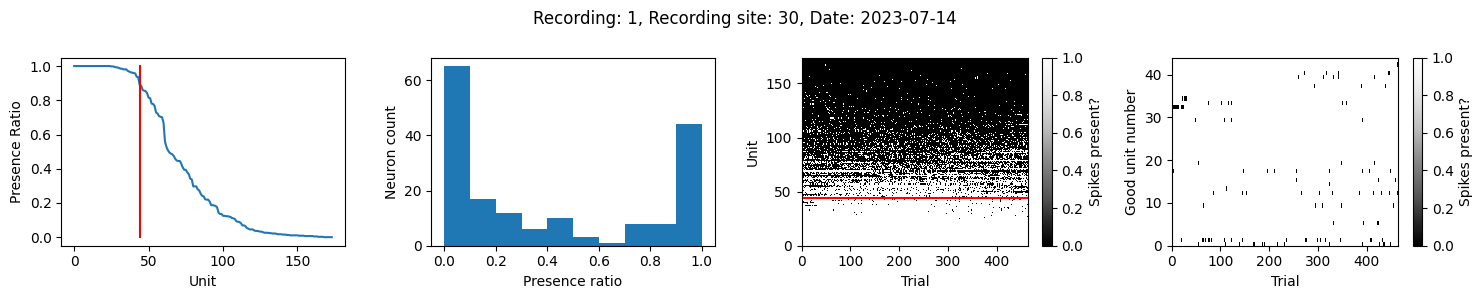

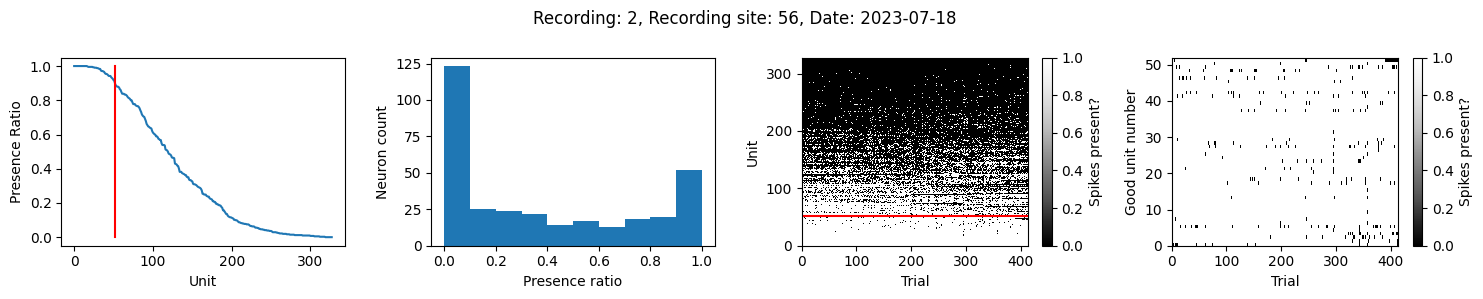

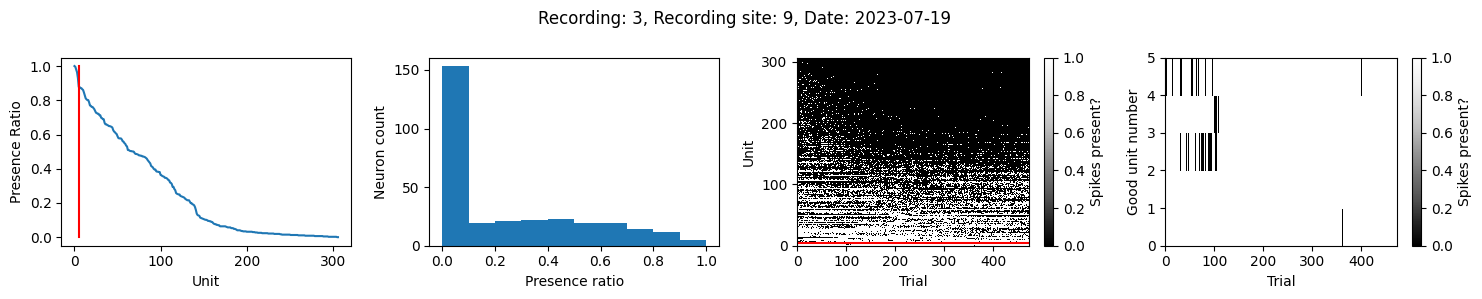

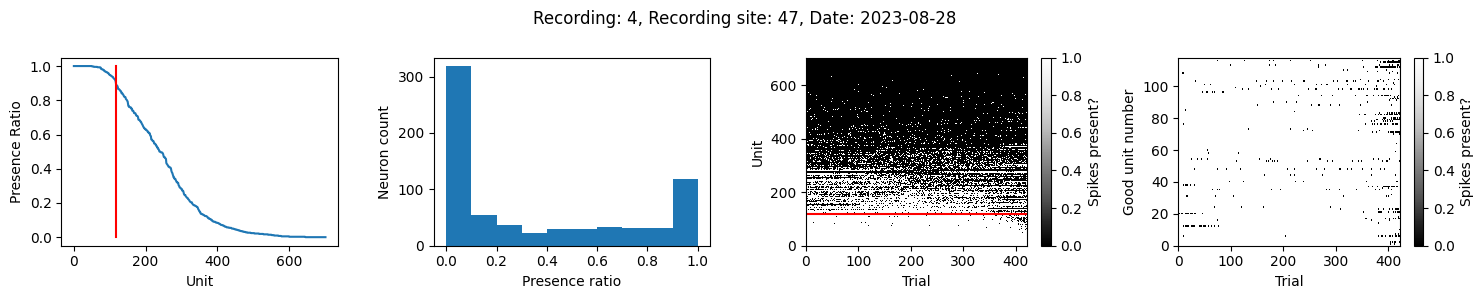

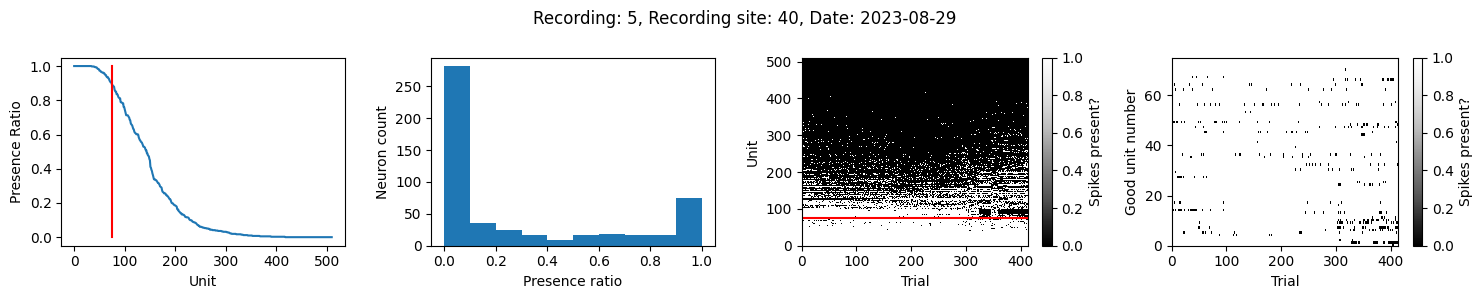

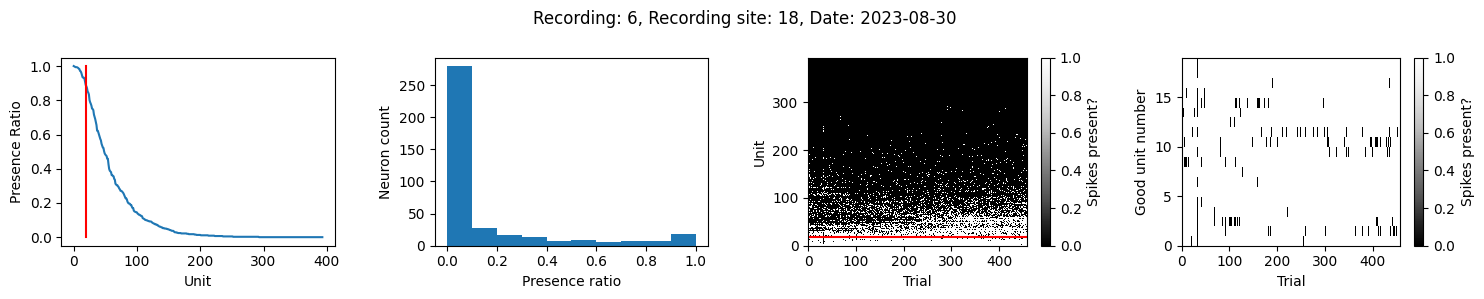

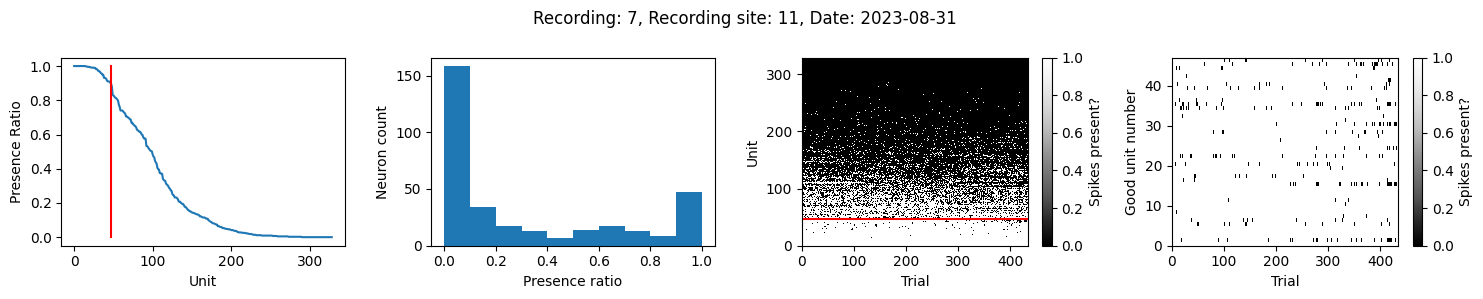

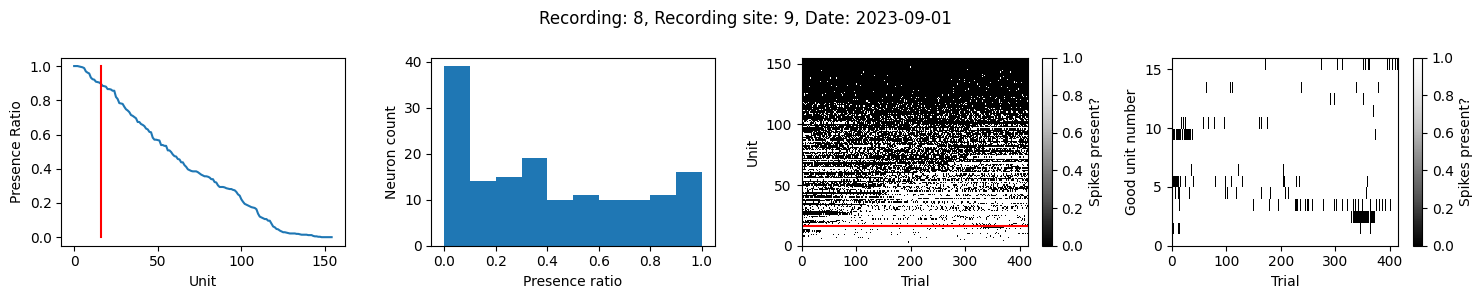

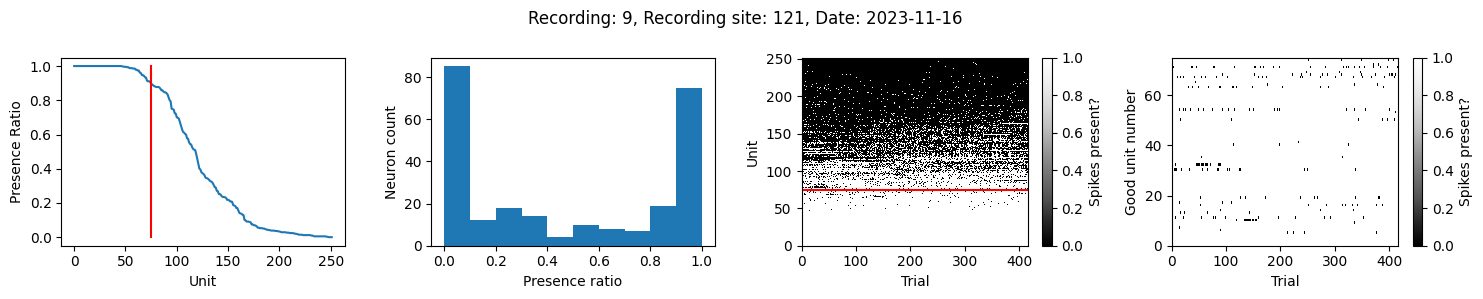

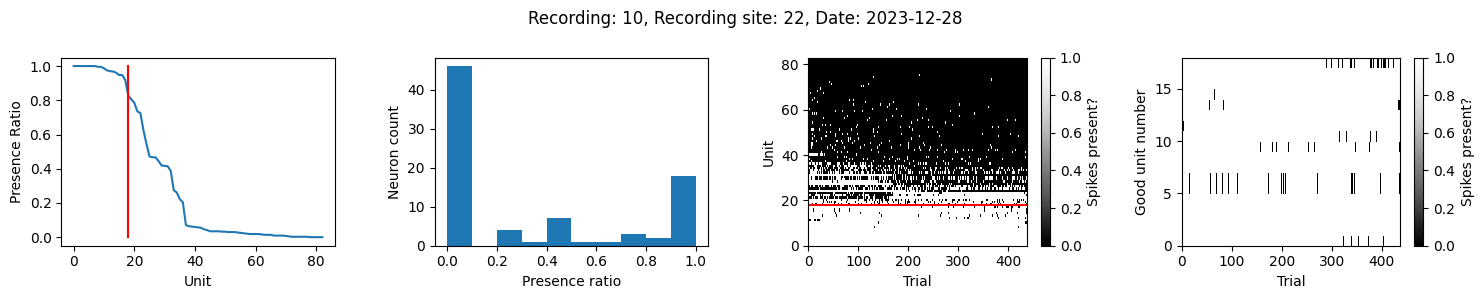

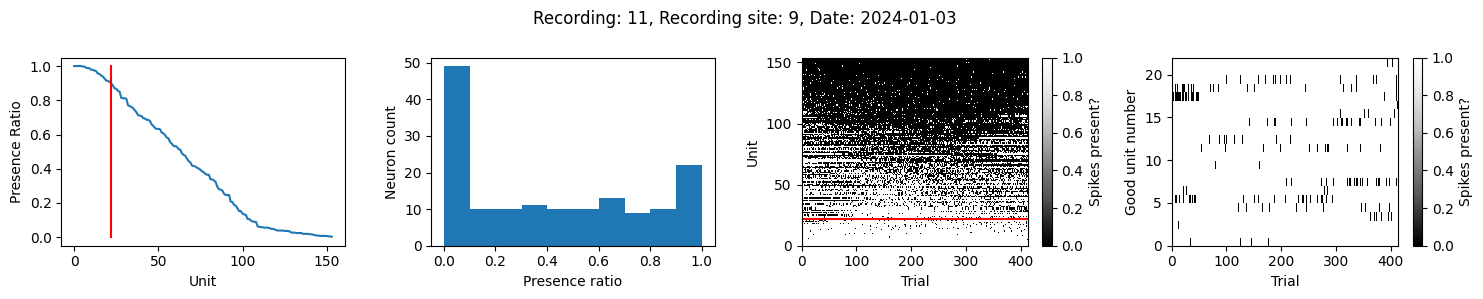

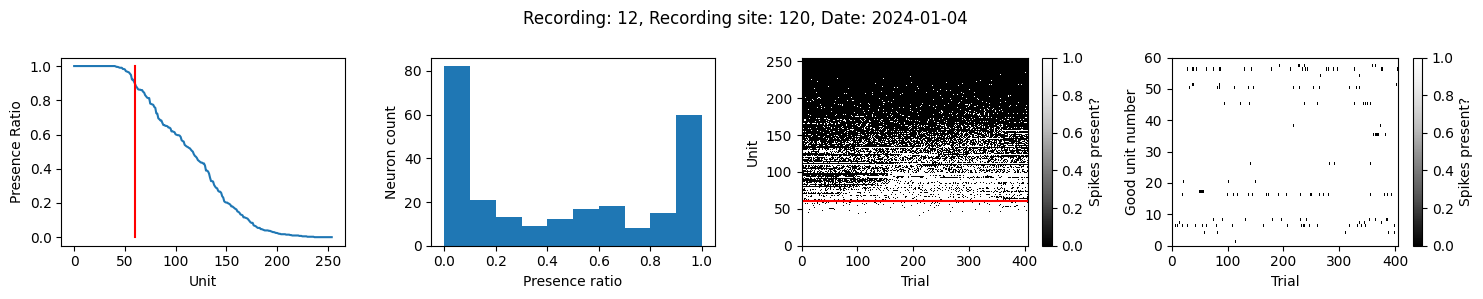

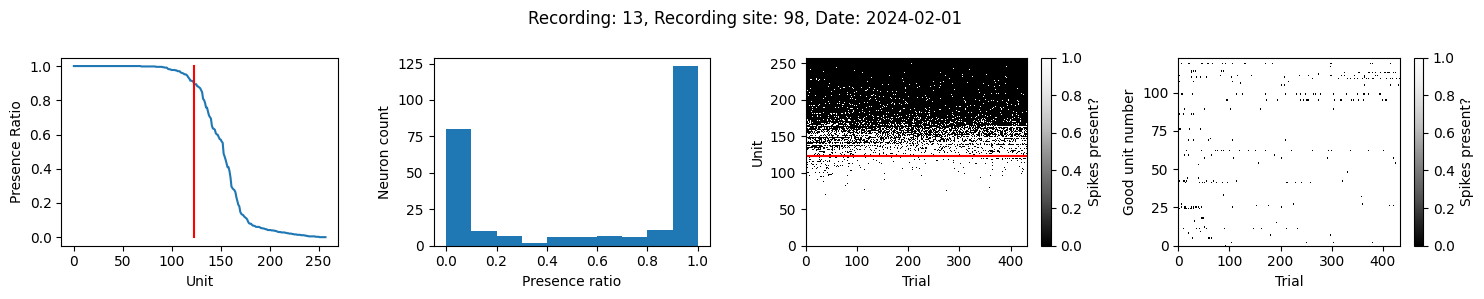

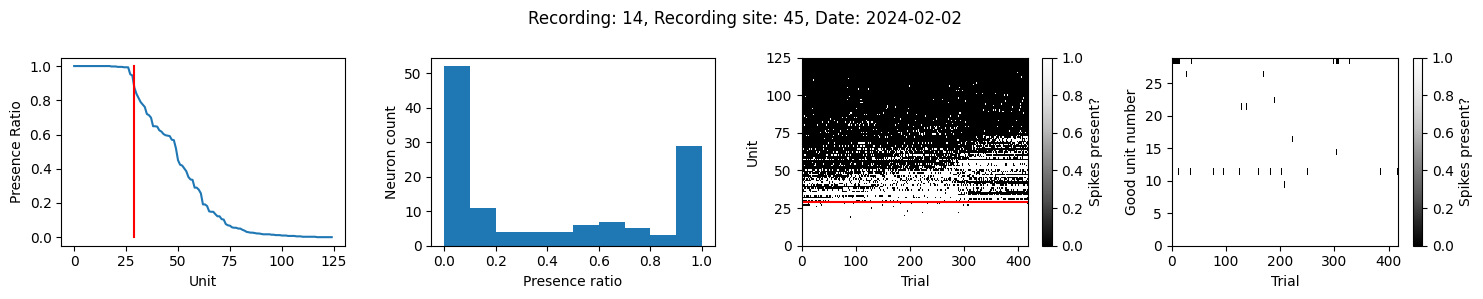

In [12]:
quality_metrics['presence_ratio'] = []
quality_metrics['present_units'] = []
quality_metrics['present_unit_labels'] = []
for irec in range(nrecs):
    ntrials = df[(df['date']==dates[irec])*df['good_trial']].reset_index()['index'].iloc[-1] - df[(df['date']==dates[irec])*df['good_trial']].reset_index()['index'].iloc[0]
    presence_ratio, present_units, presence_details = calc_presence_ratio(rasters['neural'][align_events[-1]][irec][:,:ntrials,:], min_trial_prop=min_trial_prop, return_details=True)
    # ntrials = rasters['neural'][align_events[-1]][irec].shape[1]
    
    fig, ax = plt.subplots(1,4,figsize=(15,3))
    ax[0].plot(presence_ratio[np.flip(np.argsort(presence_ratio))])
    ax[0].plot([np.sum(present_units), np.sum(present_units)], [0,1], 'r', label='Neuron cutoff')
    ax[0].set(xlabel='Unit', ylabel='Presence Ratio')
    
    ax[1].hist(presence_ratio, bins=int(np.round(1/(1-min_trial_prop))))
    ax[1].set(xlabel='Presence ratio', ylabel='Neuron count')
    
    pdetails_im = ax[2].pcolor(presence_details[:,np.flip(np.argsort(presence_ratio))].T,cmap='Greys_r')
    ax[2].plot([0, ntrials], [np.sum(present_units), np.sum(present_units)], 'r', label='Neuron cutoff')
    ax[2].set(xlabel='Trial', ylabel='Unit')
    cb = plt.colorbar(pdetails_im, label='Spikes present?')
              
    pdetails_im = ax[3].pcolor(presence_details[:,present_units].T,cmap='Greys_r')
    ax[3].set(xlabel='Trial', ylabel='Good unit number')
    cb = plt.colorbar(pdetails_im, label='Spikes present?')
        
    plt.suptitle(f"Recording: {irec}, Recording site: {recording_site[irec]}, Date: {dates[irec]}")
    fig.tight_layout()
    plt.show()
    
    quality_metrics['presence_ratio'].append(presence_ratio)
    quality_metrics['present_units'].append(present_units)
    quality_metrics['present_unit_labels'].append(list(df['unit_labels'][df['date']==dates[irec]])[0][present_units])

## Firing Rate

In [13]:
from statsmodels.stats.multitest import fdrcorrection
def get_stable_FR_units(data, wind_size=17, alpha=0.05, correction='bonferroni', return_significance=False):
    '''
    Args:
        data (ntime, ntrial, nunit): Binned and trial aligned firing rate
        wind_size (int): Size of rolling average window [trials] used to smooth firing rate. Typically large enough to average out any tuning seen by a neuron
        alpha (float): significance level
        correction (string): Type of multiple comparison correction to do ('bonferroni' or 'fdr') 
        return_significance (bool): If the linear fit significance should be returned 
    '''        
    ntime, ntrials, nunits = data.shape
    
    avg_fr_each_trial = np.mean(data, axis=0)
    smooth_avg_fr_each_trial = aopy.analysis.base.calc_rolling_average(avg_fr_each_trial, window_size=17) # move window size to input args
    
    # # stable_units = np.std(smooth_avg_fr_each_trial/(np.max(smooth_avg_fr_each_trial,axis=0)-np.min(smooth_avg_fr_each_trial,axis=0)), axis=0) < 0.25 # move threshold to input args
    pccs = []
    [pccs.append(aopy.analysis.base.linear_fit_analysis2D(np.arange(ntrials), smooth_avg_fr_each_trial[:,iunit])[3]) for iunit in range(nunits)]
    
    if correction == 'bonferroni':
        stable_units = np.array(pccs) > (0.05/nunits)
    elif correction == 'fdr':
        stable_units = np.logical_not(fdrcorrection(np.array(pccs), alpha=0.05)[0])
    else:
        print('Please enter a valid multiple comparison method')
        
    if return_significance:
        return stable_units, np.array(pccs)
    else:
        return stable_units

In [14]:
fr_trial_window_size=17
quality_metrics['stable_fr_units'] = []
quality_metrics['stable_fr_units_labels'] = []
quality_metrics['stable_fr_units_pcc'] = []
for irec in range(nrecs):
    _, present_units = calc_presence_ratio(rasters['neural'][align_events[-1]][irec], min_trial_prop=0.3, return_details=False) # set a low minimum trial threshold so neurons with very few spikes aren't used
    
    stable_units, pccs =  get_stable_FR_units(rasters['neural'][align_events[-1]][irec][:,:,present_units], wind_size=17, alpha=0.01, correction='fdr', return_significance=True)
    
    quality_metrics['stable_fr_units'].append(np.where(present_units)[0][stable_units])
    quality_metrics['stable_fr_units_pcc'].append(pccs[stable_units])
    quality_metrics['stable_fr_units_labels'] = list(df['unit_labels'][df['date']==dates[irec]])[0][np.where(present_units)[0][stable_units]]

In [15]:
print(f"Number of stable units in each recording: {[len(quality_metrics['stable_fr_units'][irec]) for irec in range(nrecs)]}")

Number of stable units in each recording: [4, 2, 7, 5, 2, 17, 2, 4, 5, 11, 5, 9, 7, 13, 2]


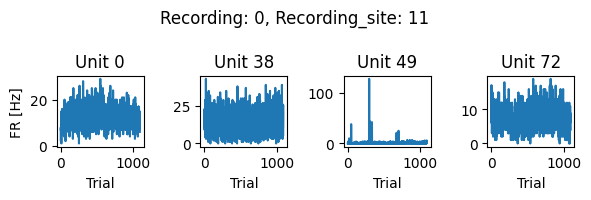

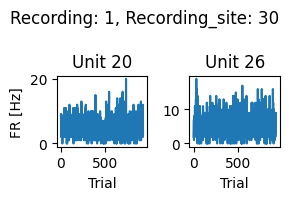

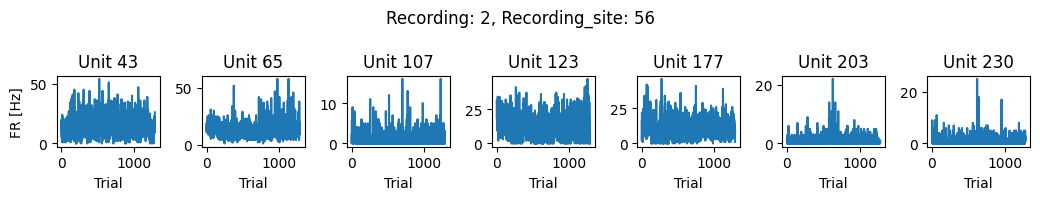

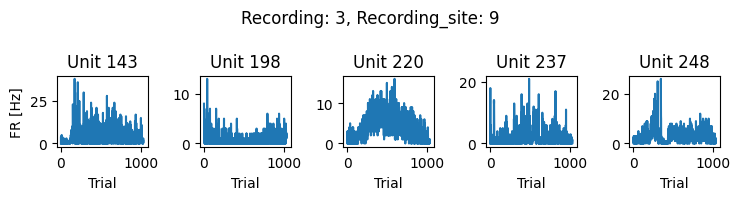

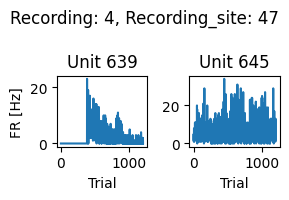

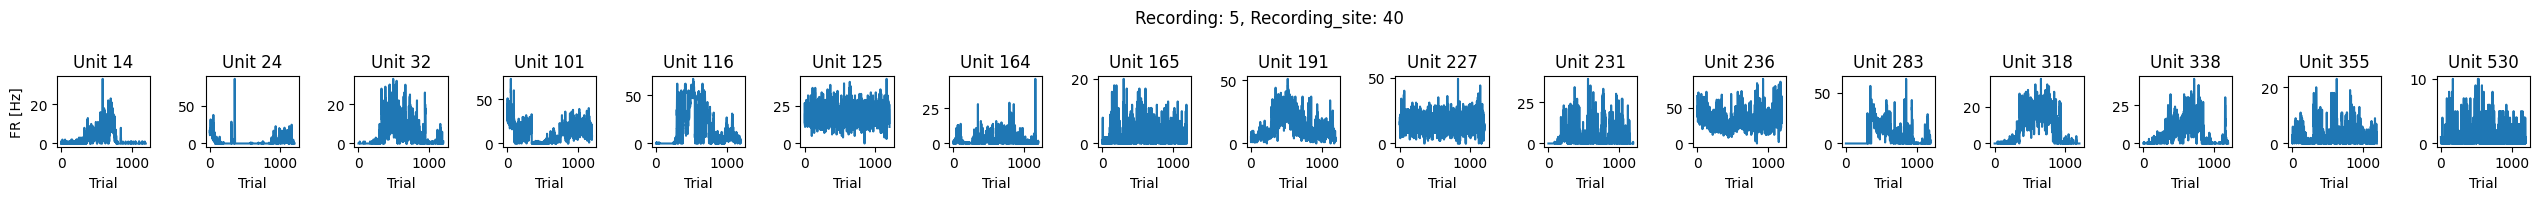

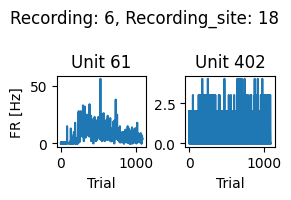

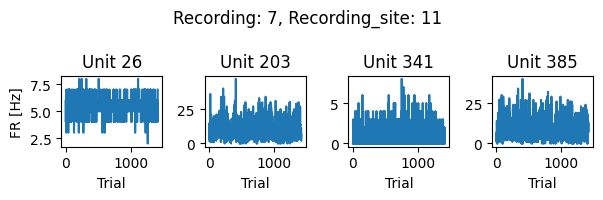

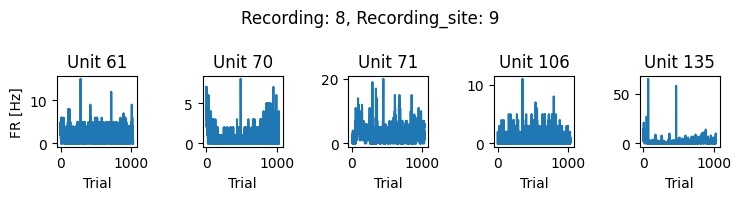

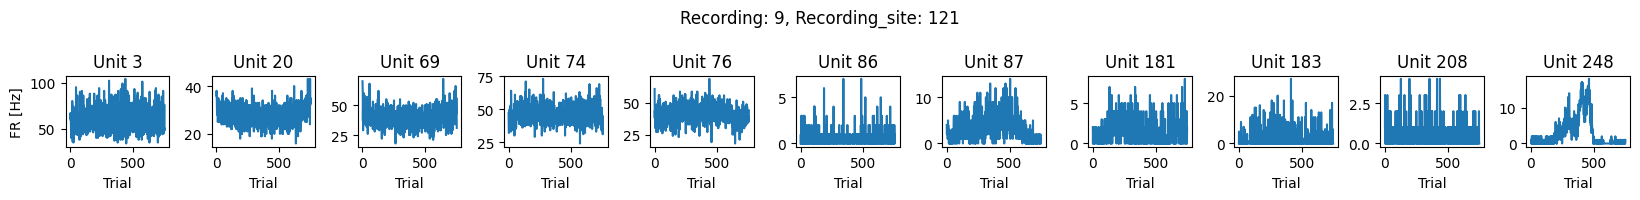

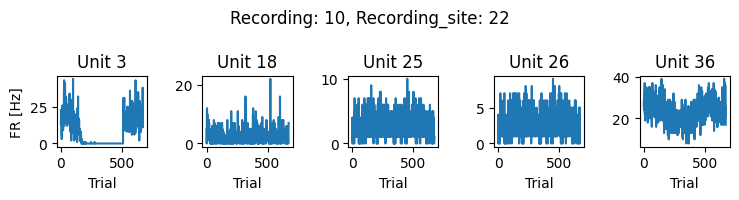

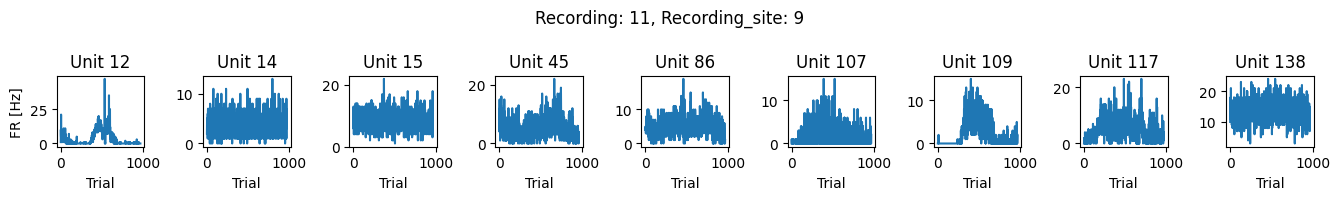

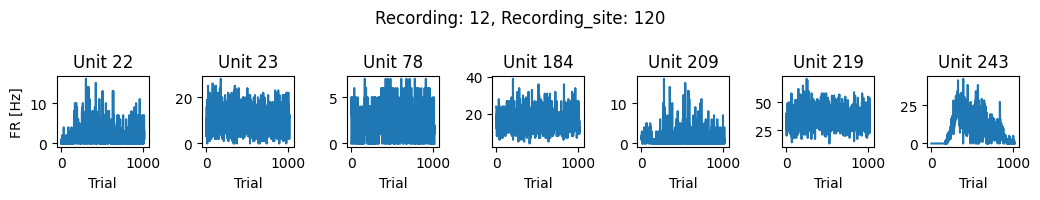

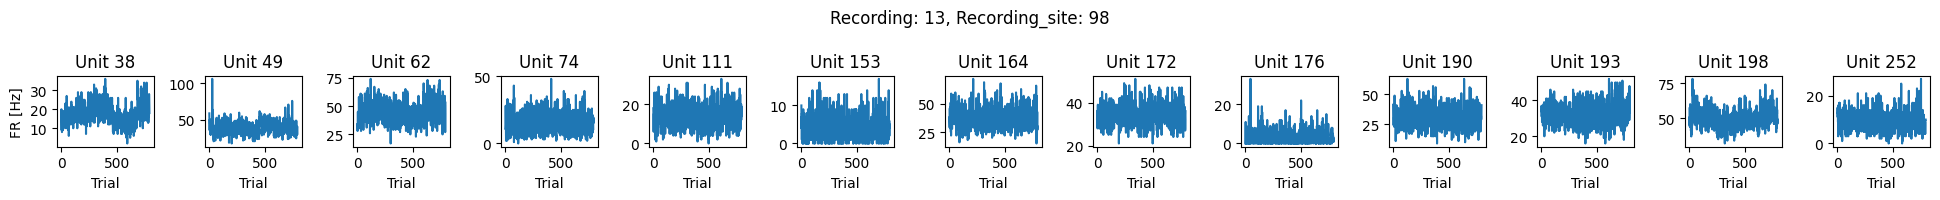

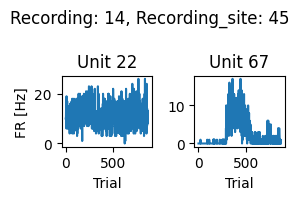

In [16]:
for irec in range(nrecs):
    nstable_units = len(quality_metrics['stable_fr_units'][irec])
    fig, ax = plt.subplots(1,nstable_units,figsize=(nstable_units*1.5,2))
    if nstable_units > 1:
        [ax[iax].plot(np.mean(rasters['neural'][align_events[-1]][irec], axis=0)[:,quality_metrics['stable_fr_units'][irec][iax]]) for iax in range(len(ax))]
        ax[0].set(ylabel='FR [Hz]')
        rec_unit_labels = list(df['unit_labels'][df['date']==dates[irec]])[0]
        [ax[iax].set(xlabel='Trial', title=f"Unit {rec_unit_labels[quality_metrics['stable_fr_units'][irec][iax]]}") for iax in range(len(ax))]
    else:
        ax.plot(np.mean(rasters['neural'][align_events[-1]][irec], axis=0)[:,quality_metrics['stable_fr_units'][irec]])
        ax.set(ylabel='FR [Hz]')
        rec_unit_labels = list(df['unit_labels'][df['date']==dates[irec]])[0]
        ax.set(xlabel='Trial', title=f"Unit {rec_unit_labels[quality_metrics['stable_fr_units'][irec]]}")
    plt.suptitle(f"Recording: {irec}, Recording_site: {recording_site[irec]}")
    fig.tight_layout()
    plt.show()

## ISI Violations

In [17]:
def get_units_without_refractory_violations(preproc_dir, subject, te_id, date, ref_perc_thresh=0.01, min_ref_period=1):
    '''
    Load data directly from kilosort output to find units with refractory period violations
    
    Args:
        preproc_dir (str): 
        date:
        te:
        subject:
        min_ref_period (float): [ms]
        
    Returns: 
        good_unit_labels:        
    '''
    filename = aopy.data.get_preprocessed_filename(subject, te_id, date, 'ap')
    ap_data = aopy.data.load_hdf_group(os.path.join(preproc_dir, subject), filename, 'ap')
    nunits = len(ap_data['unit'].keys())
    
    ref_violations = np.zeros(nunits)*np.nan
    good_unit_labels = []
    for iunit, unit_lbl in enumerate(list(ap_data['unit'].keys())):
        nspikes = len(ap_data['unit'][unit_lbl])
        ref_violations[iunit] = np.sum(np.diff(ap_data['unit'][unit_lbl]) < (min_ref_period/1000)) # convert from [ms] to [s]
        
        if (ref_violations[iunit]/nspikes) <= ref_perc_thresh:
            good_unit_labels.append(unit_lbl)
    
    return good_unit_labels, ref_violations

In [18]:
quality_metrics['ISI_threshold_units'] = []
unique_teid, unique_idx = np.unique(df['te_id'], return_index=True)
unique_dates = np.array(df['date'][unique_idx])
for idate, date in enumerate(tqdm(dates)):
    date_tes = unique_teid[unique_dates==date]
    temp_cnt = 0
    for ite in date_tes:
        # Load data
        filename_mc = aopy.data.get_preprocessed_filename(subject, ite, date, 'ap')
        try:
            ap_data = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), filename_mc, 'ap')

        except:
            continue

        # find units that pass refractory violation threshold
        temp_good_unit_labels, _ = get_units_without_refractory_violations(data_path_preproc, subject, ite, date)

        if temp_cnt == 0:
            good_unit_labels = np.array(temp_good_unit_labels) 
        else:
            good_unit_labels = good_unit_labels[np.in1d(good_unit_labels, np.array(temp_good_unit_labels))]

        temp_cnt += 1

    # only use units that pass for all recordings
    quality_metrics['ISI_threshold_units'].append(good_unit_labels)

  0%|          | 0/15 [00:00<?, ?it/s]

## Amplitude threshold

In [19]:
def get_high_amplitude_units(preproc_dir, subject, te_id, date, amp_thresh=50):
    '''
    Calculates peak to peak amplitude for all channels then uses the largest one
    '''
    # Load data
    filename = aopy.data.get_preprocessed_filename(subject, te_id, date, 'ap')
    ap_data = aopy.data.load_hdf_group(os.path.join(preproc_dir, subject), filename, 'ap')
    ap_metadata = aopy.data.load_hdf_group(os.path.join(preproc_dir, subject), filename_mc, 'metadata') # TODO different preproc dir?

    # Initialize variables
    nunits = len(ap_data['unit'].keys())
    nwf_time = ap_data['waveform'][str(ap_data['unique_label'][0])].shape[1]
    ref_violations = np.zeros(nunits)*np.nan
    good_unit_labels = []
    mean_wfs = []
    for iunit, unit_lbl in enumerate(list(ap_data['unit'].keys())):
        cent_wfs = ap_data['waveform'][str(unit_lbl)] - np.mean(ap_data['waveform'][str(unit_lbl)], axis=1)[:,None,:] # Center each spike on each channel
        mean_wf = np.mean(cent_wfs, axis=0)*ap_metadata['bit_volts'][0] # Mean across all spikes for each channel. becomes (ntime, nch) array
        
        p2p = np.abs(np.max(mean_wf, axis=0) - np.min(mean_wf, axis=0)) # Peak to peak amplitude for each channel
        
        if np.max(p2p) > amp_thresh:
            good_unit_labels.append(unit_lbl)
            mean_wfs.append(mean_wf[:,np.argmax(p2p)])
            
            
    return good_unit_labels, mean_wfs

In [20]:
amp_thresh = 25
quality_metrics['high_amp_units'] = []
unique_teid, unique_idx = np.unique(df['te_id'], return_index=True)
unique_dates = np.array(df['date'][unique_idx])
for idate, date in enumerate(tqdm(dates)):
    date_tes = unique_teid[unique_dates==date]
    temp_cnt = 0
    for ite in date_tes:
        # Load data
        filename_mc = aopy.data.get_preprocessed_filename(subject, ite, date, 'ap')
        try:
            ap_data = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), filename_mc, 'ap')

        except:
            continue

        # find units that pass amplitude threshold and get wfs
        temp_good_unit_labels, temp_wfs = get_high_amplitude_units(data_path_preproc, subject, ite, date, amp_thresh=amp_thresh)

        if temp_cnt == 0:
            good_unit_labels = np.array(temp_good_unit_labels) 
        else:
            good_unit_labels = good_unit_labels[np.in1d(good_unit_labels, np.array(temp_good_unit_labels))]

        temp_cnt += 1
        
    # only use units that pass for all recordings
    quality_metrics['high_amp_units'].append(good_unit_labels)

  0%|          | 0/15 [00:00<?, ?it/s]

## Noise cutoff

In [21]:
def extract_ks_template_amplitudes(kilosort_dir, subject, te, date_ks, rec_site, max_time=None):
    '''
    Estimate if the amplitude distribution of a unit is cutoff by the noise threshold in the kilosort deconvolution
    
    Args:
        kilosort_dir (str):
        subject (str):
        te (list):
        date_ks (date):
        rec_site (int):
        max_time (float): [s]
    '''
    from datetime import date
    ks_folder_name_cutoff = date(2023, 8, 15)
    if date_ks > ks_folder_name_cutoff:
        merged_ks_path = os.path.join(kilosort_dir, f"{date_ks}_Neuropixel_ks_{subject}_site{rec_site}_bottom_port1")
        entry_ks_path = [os.path.join(kilosort_dir, f"{date_ks}_Neuropixel_ks_{subject}_site{rec_site}_bottom_port1_{ite}") for ite in te]
    else:
        merged_ks_path = os.path.join(kilosort_dir, f"{date_ks}_Neuropixel_ks_{subject}_bottom_port1")
        entry_ks_path = [os.path.join(kilosort_dir, f"{date_ks}_Neuropixel_ks_{subject}_bottom_port1_{ite}") for ite in te]
    
    samplerate = 30000 # Neuropixel AP data acq samplerate. Shouldn't change    
    
    # Load combined trains to go into and grab what we need
    spike_times = np.load(os.path.join(merged_ks_path, 'kilosort_output/spike_times.npy'))
    template_features = np.load(os.path.join(merged_ks_path, 'kilosort_output/template_features.npy'))
    paths = np.load(os.path.join(merged_ks_path, 'task_path.npy'))
    combined_tes = [int(path[-len(str(te[0])):]) for path in paths]
    datasize = np.load(os.path.join(merged_ks_path, 'datasize_entry.npy'))
    template_amps = {}
    for ii, ite in enumerate(te):
        spike_times_entry = np.load(os.path.join(entry_ks_path[ii], 'spike_indices_entry.npy'))
        spike_labels = np.load(os.path.join(entry_ks_path[ii], 'spike_clusters_entry.npy'))
        
        # Find offset based on which TE is being looked at
        ientry_combined = np.where(np.isin(combined_tes, ite))[0][0]
        
        if ientry_combined > 0:
            offset = np.sum(datasize[:ientry_combined])
        else:
            offset = 0
        
        start_idx = np.where(spike_times == int(offset+np.min(spike_times_entry)))[0][0] # First spike of the combined spike train for this TE
        end_idx = np.where(spike_times == int(offset+np.max(spike_times_entry)))[0][-1] # Last spike of the combined spike train for this TE
        template_features_te = template_features[start_idx:end_idx+1,:]

        # Separate into clusters
        cluster_labels = np.unique(spike_labels)
        for icluster in cluster_labels:
            
            icluster_mask = np.isin(spike_labels, icluster)
            # print(spike_times_entry.shape, icluster_mask.shape, template_features_te.shape)
            spike_times_cluster = spike_times_entry[icluster_mask]
            template_amp_temp = np.max(template_features_te[icluster_mask,:], axis=1)
            
            if max_time is not None:
                template_amp_temp = template_amp_temp[spike_times_cluster < int(max_time*samplerate)]
                
            if icluster in list(template_amps.keys()):
                template_amps[icluster] = np.concatenate((template_amps[icluster], template_amp_temp))
            else:
                template_amps[icluster] = template_amp_temp
                
    return template_amps

def apply_noise_cutoff_thresh(template_amps, bin_width=0.1, low_bin_thresh=0.1, uhq_std_thresh=5):
    unit_labels = list(template_amps.keys())
    low_bin_perc = np.zeros(len(unit_labels))*np.nan
    cutoff_metric = np.zeros(len(unit_labels))*np.nan
    result = np.zeros(len(unit_labels), dtype=bool)
    
    for ii, unit_lbl in enumerate(unit_labels):
        if len(amps[unit_lbl]) > 10:
            bins = np.arange(np.min(amps[unit_lbl]), np.max(amps[unit_lbl]), bin_width)
            hist, bin_edges = np.histogram(amps[unit_lbl], bins=bins)
            peak_value = np.max(hist)
            low_bin = hist[0]
            low_bin_perc_temp = low_bin/peak_value
            low_bin_perc[ii] = low_bin_perc_temp

            # Compute upper-half-quantile metrics (uhq)
            max_amp = bin_edges[np.argmax(hist)]+(bin_width/2)
            uhq_thresh = np.quantile(amps[unit_lbl][amps[unit_lbl] > max_amp], 0.75)
            uhq_amps = amps[unit_lbl][amps[unit_lbl] > uhq_thresh]
            uhq_hist, _ = np.histogram(uhq_amps, bins=np.arange(np.min(uhq_amps), np.max(uhq_amps), 0.1))
            uhq_mean = np.mean(uhq_hist)
            uhq_std = np.std(uhq_hist)
            cutoff_metric_temp = np.abs(low_bin-uhq_mean)/uhq_std
            cutoff_metric[ii] = cutoff_metric_temp

            if low_bin_perc_temp <= low_bin_thresh and cutoff_metric_temp <= uhq_std_thresh:
                result[ii] = True
        
    return result, low_bin_perc, cutoff_metric
# amps = extract_ks_template_amplitudes(kilosort_dir, subject, [9924, 9925], dates[0], 11, max_time=None)
# good_units, low_perc, cutoff_metric = apply_noise_cutoff_thresh(amps, bin_width=0.1, low_bin_thresh=0.1, uhq_std_thresh=5)

In [22]:
# print(df[df['date']==date].reset_index())

temp_df = df[df['date']==date].reset_index()
list(temp_df['event_times'][temp_df['good_trial']])[-1][-1]

878.15124

In [23]:
quality_metrics['noise_cutoff_labels'] = []
unique_teid, unique_idx = np.unique(df['te_id'], return_index=True)
unique_dates = np.array(df['date'][unique_idx])

for idate, date in enumerate(tqdm(dates[:])):
    temp_df = df[df['date']==date].reset_index()
    max_time_date = list(temp_df['event_times'][temp_df['good_trial']])[-1][-1]+1
    
    date_tes = unique_teid[unique_dates==date]
    amps = extract_ks_template_amplitudes(kilosort_dir, subject, date_tes, date, list(df['recording_site'][df['date']==date])[0],max_time=max_time_date)
    noise_unit_labels = np.array(list(amps.keys()))
    good_units, low_perc, cutoff_metric = apply_noise_cutoff_thresh(amps, bin_width=0.1, low_bin_thresh=0.25, uhq_std_thresh=5)
    quality_metrics['noise_cutoff_labels'].append(noise_unit_labels[good_units])

  0%|          | 0/15 [00:00<?, ?it/s]

/home/aolab/miniconda3/envs/np_targeting/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aolab/miniconda3/envs/np_targeting/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/aolab/miniconda3/envs/np_targeting/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/aolab/miniconda3/envs/np_targeting/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/aolab/miniconda3/envs/np_targeting/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/aolab/min

In [24]:
# temp_unit_lbl = 8
# bin_width = 0.1
# bins = np.arange(np.min(amps[temp_unit_lbl]), np.max(amps[temp_unit_lbl]), 0.1)
# hist, bin_edges = np.histogram(amps[temp_unit_lbl], bins=bins)
# peak_value = np.max(hist)
# low_bin = hist[0]
# low_bin_perc = low_bin/peak_value
# # print(hist, bin_edges)
# # print(low_bin_perc)
# max_amp = bin_edges[np.argmax(hist)]+(bin_width/2)
# bins_over_max = bin_edges[bin_edges > max_amp]
# uhq_amps = hist[-(len(bins_over_max)-1):]
# print(uhq_amps)
# # nbins_over_max = len(bin_edges[bin_edges > max_amp])
# # uhq_amps = hist[-int((nbins_over_max-1)/4):]
# # uhq_mean = np.mean(uhq_hist)
# # uhq_std = np.std(uhq_hist)
# upper_half_quantile_thresh = np.quantile(amps[temp_unit_lbl][amps[temp_unit_lbl] > max_amp], 0.75)
# upper_half_quantile_amps = amps[temp_unit_lbl][amps[temp_unit_lbl] > upper_half_quantile_thresh]
# uhq_hist, _ = np.histogram(upper_half_quantile_amps, bins=np.arange(np.min(upper_half_quantile_amps), np.max(upper_half_quantile_amps), 0.1))
# uhq_mean = np.mean(uhq_hist)
# uhq_std = np.std(uhq_hist)
# print(uhq_mean, uhq_std)
# # sorted_amps = np.sort
# fig, ax = plt.subplots(1,1)
# ax.hist(amps[temp_unit_lbl], bins=bins)
# ax.hist(upper_half_quantile_amps, bins=bins)
# ax.plot([max_amp, max_amp], ax.get_ylim(), 'r')
# ax.plot(ax.get_xlim(), [uhq_mean, uhq_mean], 'g')
# ax.plot(ax.get_xlim(), [uhq_mean+(5*uhq_std), uhq_mean+(5*uhq_std)], 'g')
# plt.show()

# Apply all QC metrics

In [25]:
# neuropixel_qc_kwargs = {'presence': {}, 'stability': {}, 'isi': {}, 'amplitude':{}}

# # Save presence ratio arguments
# neuropixel_qc_kwargs['presence']['apply'] = True
# neuropixel_qc_kwargs['presence']['min_trial_prop'] = 0.9
# neuropixel_qc_kwargs['presence']['data'] = 0.9

# # Save FR stability arguments
# neuropixel_qc_kwargs['stability']['apply'] = False
# neuropixel_qc_kwargs['stability']['wind_size'] = 17
# neuropixel_qc_kwargs['stability']['alpha'] = 0.01
# neuropixel_qc_kwargs['stability']['data'] = 0.9

# # Save ISI violation arguments
# neuropixel_qc_kwargs['isi']['apply'] = False
# neuropixel_qc_kwargs['isi']['preproc_dir'] = 
# neuropixel_qc_kwargs['isi']['subject'] = 
# neuropixel_qc_kwargs['isi']['teid'] = 
# neuropixel_qc_kwargs['isi']['date'] =
# neuropixel_qc_kwargs['isi']['ref_period'] = #[ms]

# # Save WF amplitude threshold arguments
# neuropixel_qc_kwargs['amplitude']['apply'] = True
# neuropixel_qc_kwargs['amplitude']['preproc_dir'] = 
# neuropixel_qc_kwargs['amplitude']['subject'] = 
# neuropixel_qc_kwargs['amplitude']['teid'] = 
# neuropixel_qc_kwargs['amplitude']['date'] =
# neuropixel_qc_kwargs['amplitude']['amp_thres'] = #[uV]


# def get_good_neuropixel_units(**kwargs):
#     '''
#     Args:
#         data (ntime, ntrials, nunits):
#         preproc_dir ():
#         entry (tuple): (subject, id, date)
#         pr_min_trial_prop (float):
#         get_fr_stable_units (bool):
        
        
#     '''
#     subject, teid, date = entry
    
#     presence_ratio, present_units, presence_details = calc_presence_ratio(data, min_trial_prop=pr_min_trial_prop, return_details=False)    
#     stable_units, pccs =  get_stable_FR_units(data[:,:,present_units], wind_size=17, alpha=0.01, correction='fdr', return_significance=True)
#     # temp_good_unit_labels, _ = get_units_without_refractory_violations(preproc_dir, subject, teid, date, min_ref_period=1)
#     unit_labels, _ = get_high_amplitude_units(preproc_dir, subject, te_id, date, amp_thresh=50)
    
#     good_units = present_units*stable_units
    
#     return good_units

In [26]:
quality_metrics['final_good_unit_labels'] = []
quality_metrics['final_good_unit_idx'] = []
for irec in range(nrecs):
    present_unit_mask = np.in1d(np.array(list(df['unit_labels'][df['date']==dates[irec]])[0]), quality_metrics['present_unit_labels'][irec])
    stable_unit_mask = np.in1d(np.array(list(df['unit_labels'][df['date']==dates[irec]])[0]), quality_metrics['stable_fr_units'][irec])
    isi_good_unit_mask = np.in1d(np.array(list(df['unit_labels'][df['date']==dates[irec]])[0]), quality_metrics['ISI_threshold_units'][irec])
    amp_good_unit_mask = np.in1d(np.array(list(df['unit_labels'][df['date']==dates[irec]])[0]), quality_metrics['high_amp_units'][irec])
    noise_cutoff_good_unit_mask = np.in1d(np.array(list(df['unit_labels'][df['date']==dates[irec]])[0]), quality_metrics['noise_cutoff_labels'][irec])
    
    # final_good_unit_labels_temp = present_unit_mask*stable_unit_mask*isi_good_unit_mask
    final_good_unit_labels_temp = present_unit_mask*isi_good_unit_mask*amp_good_unit_mask*noise_cutoff_good_unit_mask
    # final_good_unit_labels_temp = present_unit_mask*isi_good_unit_mask*amp_good_unit_mask
    # final_good_unit_labels_temp = present_unit_mask*amp_good_unit_mask
    # final_good_unit_labels_temp = present_unit_mask
    
    if np.sum(final_good_unit_labels_temp) == 0:
        quality_metrics['final_good_unit_labels'].append([])
        quality_metrics['final_good_unit_idx'].append([])
    else:
        print(list(df['unit_labels'][df['date']==dates[irec]])[0][np.where(final_good_unit_labels_temp)[0]])
        quality_metrics['final_good_unit_labels'].append(list(df['unit_labels'][df['date']==dates[irec]])[0][np.where(final_good_unit_labels_temp)[0]])
        quality_metrics['final_good_unit_idx'].append(np.where(final_good_unit_labels_temp)[0])

[ 38  61  72 108 127]
[  9  14  19  20  25  26  27  29  30  31  44  48  49  51  57  70  75  80
  84 108 109 112 123]
[  0  80  96  97 101 102 104 109 110 118 122 123 129 132 133 140 151 154
 155 165 167 177 178 181 183 232 242 258 285 304 334 358]
[54]
[ 29  40  48  52  56  57  67  96  98 101 107 109 110 111 113 117 120 130
 137 138 143 153 161 165 166 167 169 182 184 187 188 203 207 211 220 258
 260 285 289 310 312 316 317 319 320 327 330 332 338 350 373 405 509 637
 655 668 680 683 691 749 755 848 854 905]
[ 36  59  60  62  84  88  93  96 103 105 112 122 123 125 135 137 141 146
 153 204 227 298 305 309 310 323 325 347 362 367 401 402 469 488]
[  0 220 399 416 453 455 489]
[ 11  26  28  37  45  54  55  60  88  97 125 126 141 159 163 174 176 193
 195 198 207 304 318 329 355 423 432]
[ 76  91 101]
[  0   3   4   6  11  12  15  31  39  41  43  47  49  52  57  60  63  68
  71  72  74  76  80  84  88  89  90  95  96  97  99 101 103 104 105 109
 119 127 129 133 135 136 154 166 168 196 202 2

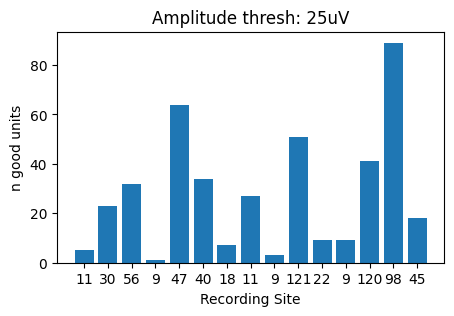

In [27]:
fig, ax = plt.subplots(1,1,figsize=(5,3))
ax.bar(np.arange(nrecs), [len(quality_metrics['final_good_unit_idx'][irec]) for irec in range(nrecs)])
ax.set(xlabel='Recording Site', ylabel='n good units', title=f"Amplitude thresh: {amp_thresh}uV")
ax.set_xticks(np.arange(nrecs), labels=recording_site)
# ax.set(ylim=(0,120))

plt.show()

## Plot waveforms of units that pass QC metrics

  0%|          | 0/15 [00:00<?, ?it/s]

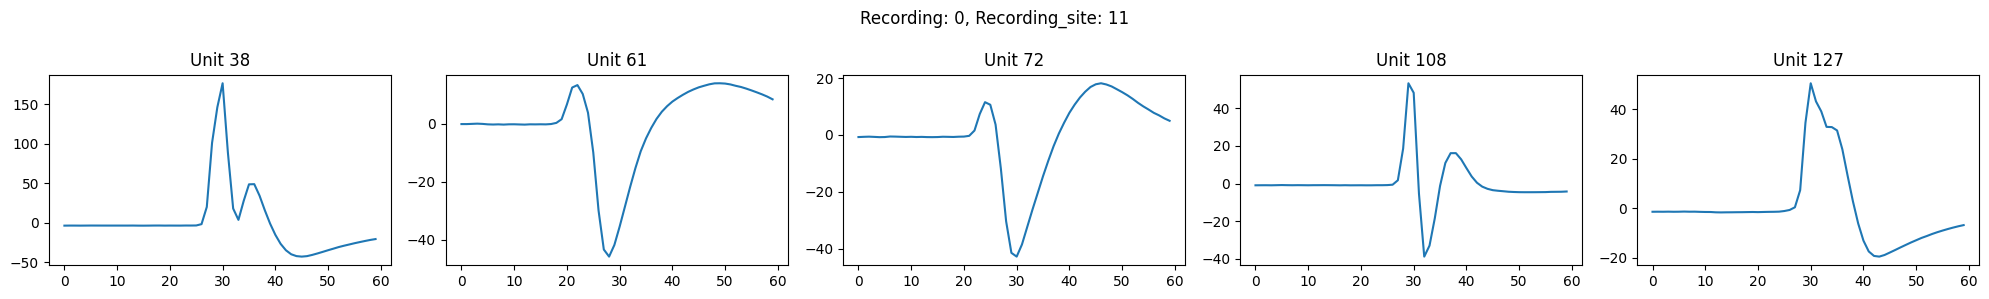

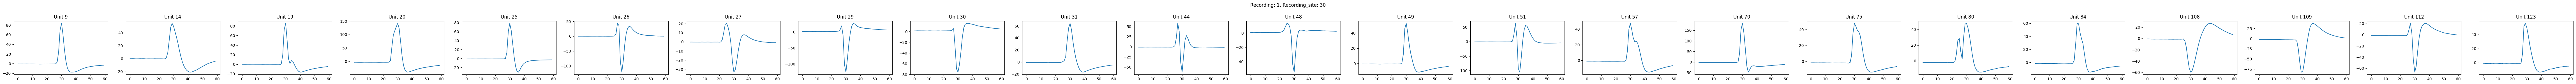

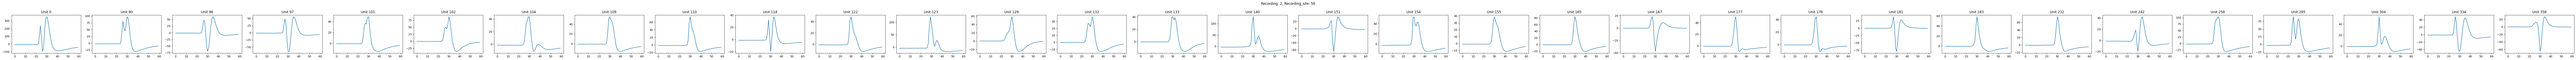

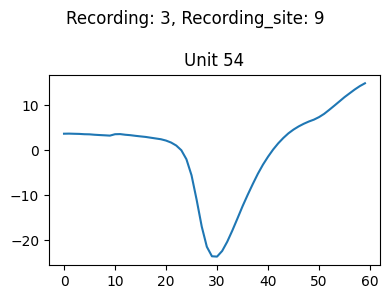

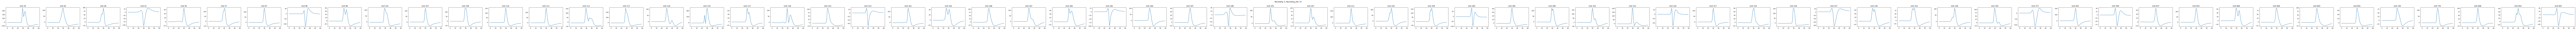

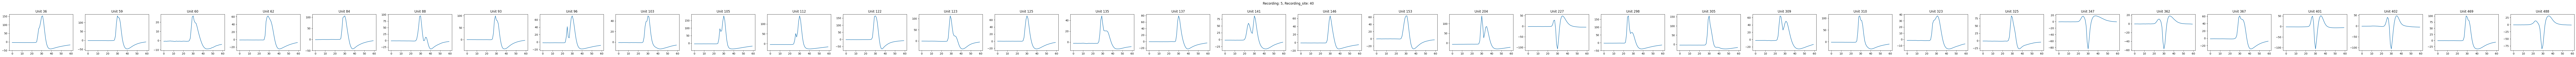

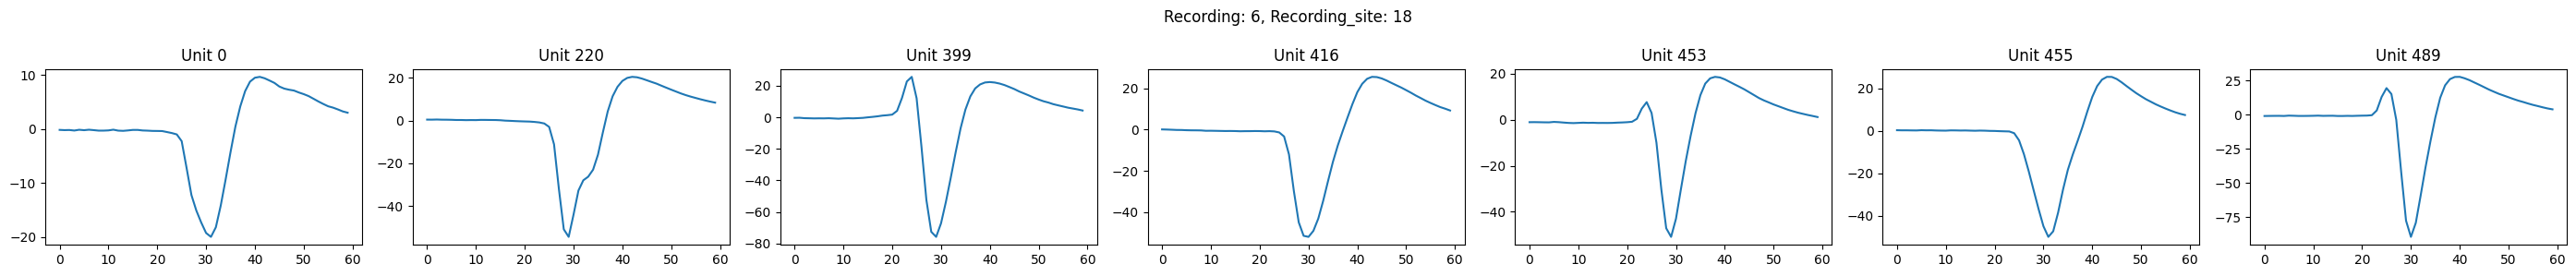

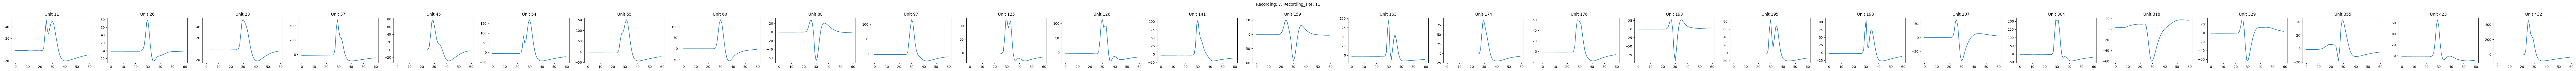

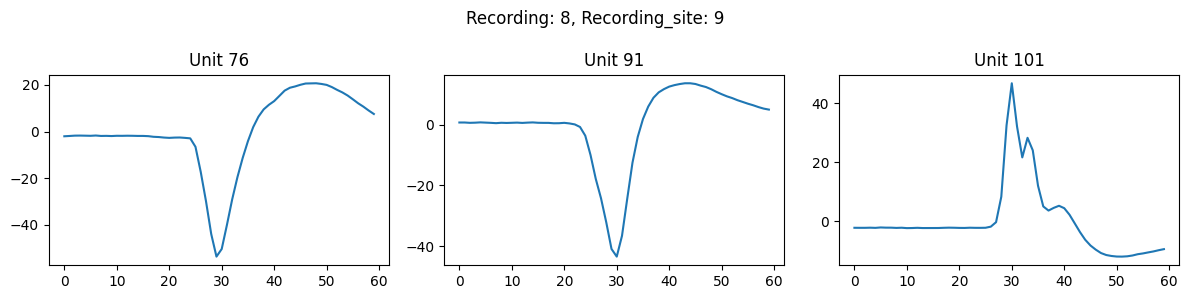

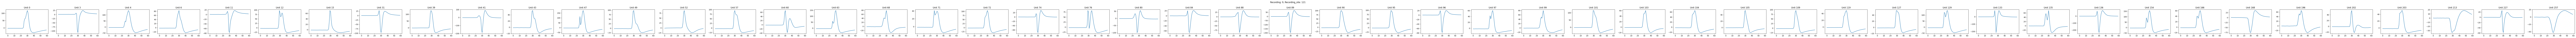

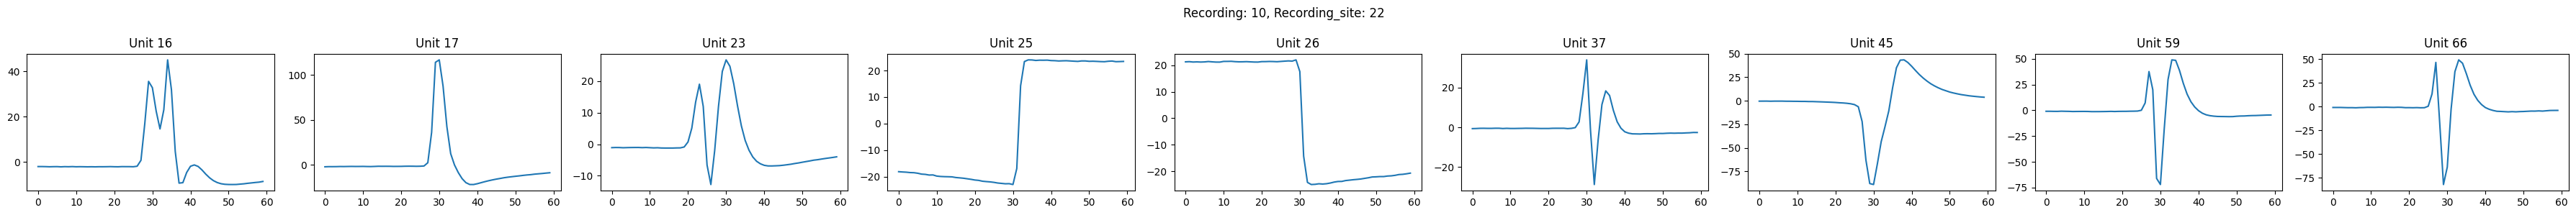

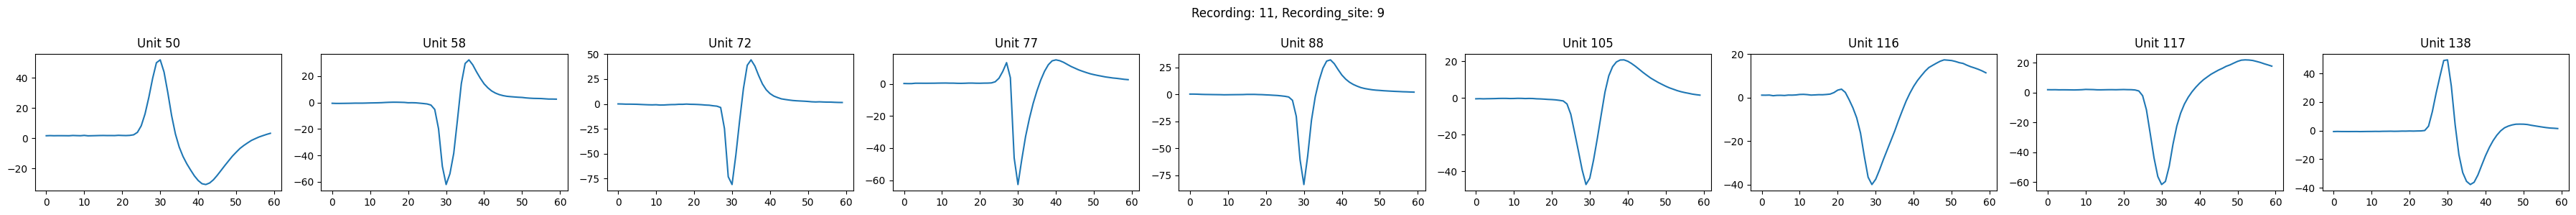

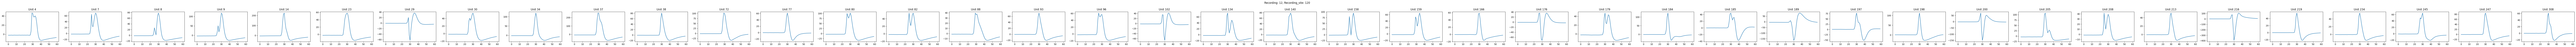

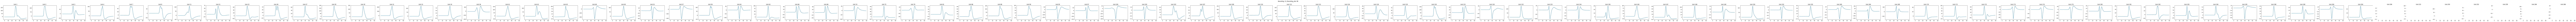

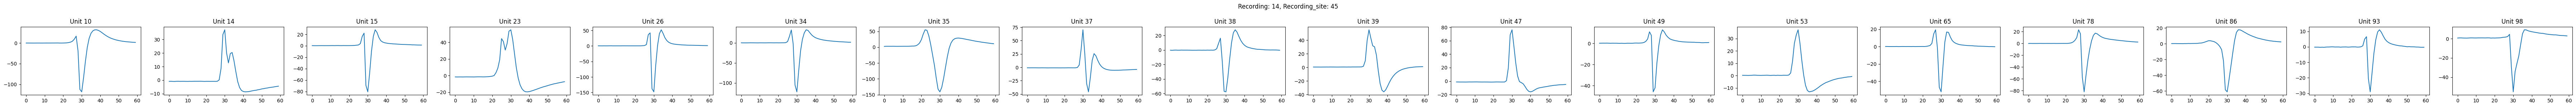

In [28]:
# Go back and load waveforms from the originally preprocessed neuropixel data
quality_metrics['mean_wfs'] = []
quality_metrics['position'] = []
unique_teid, unique_idx = np.unique(df['te_id'], return_index=True)
unique_dates = np.array(df['date'][unique_idx])

for idate, date in enumerate(tqdm(dates)):
    if len(quality_metrics['final_good_unit_labels'][idate]) > 0:
        date_tes = unique_teid[unique_dates==date]
    
        irec_wfs = {}
        irec_pos = {}
        temp_cnt = 0
        for ite in date_tes:
            # Load data
            filename_mc = aopy.data.get_preprocessed_filename(subject, ite, date, 'ap')
            try:
                ap_data = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), filename_mc, 'ap')
                ap_metadata = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), filename_mc, 'metadata')

            except:
                print(f'Could not load data for te {ite}')
                continue

            # concatenate data
            ngoodunits = len(quality_metrics['final_good_unit_labels'][idate])
            for goodunit_label in quality_metrics['final_good_unit_labels'][idate]:
                if temp_cnt == 0:
                    irec_wfs[str(goodunit_label)] = ap_data['waveform'][str(goodunit_label)]
                    irec_pos[str(goodunit_label)] = ap_data['pos'][str(goodunit_label)]
                else:
                    irec_wfs[str(goodunit_label)] = np.concatenate((irec_wfs[str(goodunit_label)], ap_data['waveform'][str(goodunit_label)]), axis=0)

            temp_cnt += 1

        # plot waveforms 
        fig, ax = plt.subplots(1,ngoodunits, figsize=(ngoodunits*4,3))
        mean_wfs = np.zeros((len(quality_metrics['final_good_unit_labels'][idate]),ap_data['waveform'][str(ap_data['unique_label'][0])].shape[1]))*np.nan
        unit_pos = np.zeros((len(quality_metrics['final_good_unit_labels'][idate])))*np.nan
        for igoodunit, goodunit_label in enumerate(quality_metrics['final_good_unit_labels'][idate]):
            cent_wfs = irec_wfs[str(goodunit_label)] - np.mean(irec_wfs[str(goodunit_label)], axis=1)[:,None,:] # Center each spike on each channel
            mean_wf = np.mean(cent_wfs, axis=0)*ap_metadata['bit_volts'][0] # Mean across all spikes for each channel. becomes (ntime, nch) array

            p2p = np.abs(np.max(mean_wf, axis=0) - np.min(mean_wf, axis=0)) # Peak to peak amplitude for each channel
            mean_wfs[igoodunit, :] = mean_wf[:,np.argmax(p2p)]
            
            
            # max_ch = np.argmax(np.max(np.abs(np.mean(irec_wfs[str(goodunit_label)], axis=0)), axis=0))
            # mean_wf_temp = np.mean(irec_wfs[str(goodunit_label)][:,:,max_ch], axis=0)
            # mean_wfs[igoodunit, :] = mean_wf_temp
            unit_pos[igoodunit] = irec_pos[str(goodunit_label)][1]
            if len(quality_metrics['final_good_unit_labels'][idate]) > 1:
                ax[igoodunit].plot(mean_wf[:,np.argmax(p2p)])
                ax[igoodunit].set(title=f"Unit {goodunit_label}")
            else:
                ax.plot(mean_wf[:,np.argmax(p2p)])
                ax.set(title=f"Unit {goodunit_label}")
        plt.suptitle(f"Recording: {idate}, Recording_site: {recording_site[idate]}")
        fig.tight_layout()
        plt.show()
        
        quality_metrics['mean_wfs'].append(mean_wfs)
        quality_metrics['position'].append(unit_pos)
    else:
        quality_metrics['mean_wfs'].append([])
        quality_metrics['position'].append([])

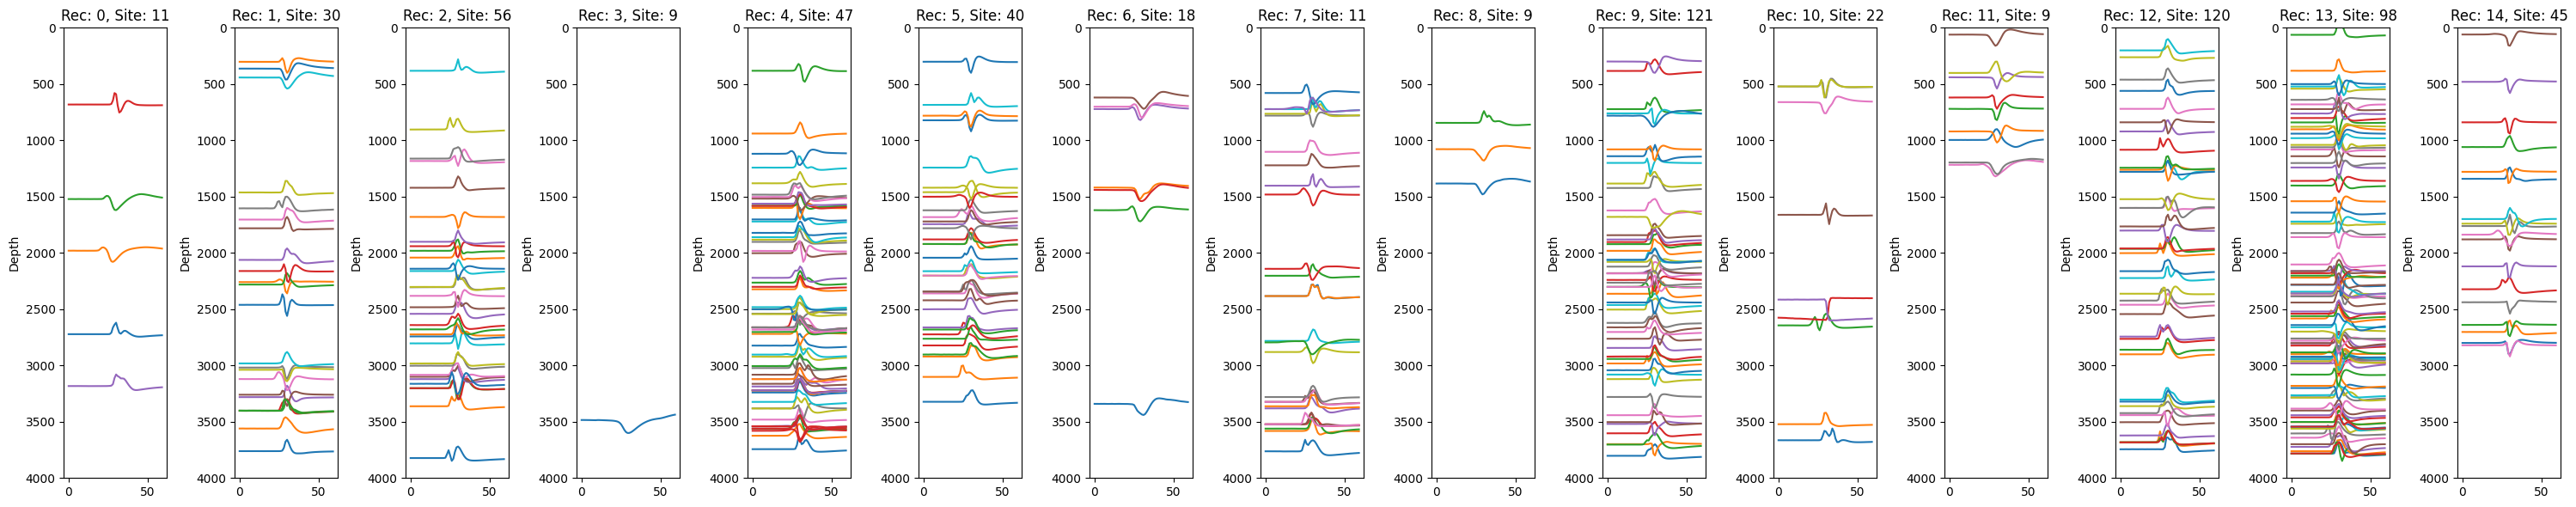

In [29]:
fig, ax = plt.subplots(1,nrecs,figsize=(2*nrecs,6))
for irec in range(nrecs):
    
    for iunit in range(len(quality_metrics['mean_wfs'][irec])):
        try:
            norm_wf = -100*quality_metrics['mean_wfs'][irec][iunit,:]/np.max(np.abs(quality_metrics['mean_wfs'][irec][iunit,:]))
            ax[irec].plot(3840 - quality_metrics['position'][irec][iunit] + norm_wf)
        except:
            continue
    
    ax[irec].set(title=(f"Rec: {irec}, Site: {recording_site[irec]}"), ylabel='Depth', ylim=(0,4000))
    ax[irec].invert_yaxis()
fig.tight_layout()
plt.show()

# Manually pick possible bad units based on waveform

In [30]:
# Manually curate - remove axons and obvious artifacts
manual_bad_unit_labels = []
manual_bad_unit_labels.append([31, 38, 82, 99, 127]) # site 11
manual_bad_unit_labels.append([8, 9 , 11, 12, 14, 15, 19, 20, 25, 31, 35, 36, 49, 52, 57, 70, 75, 78, 80, 84, 85, 88, 122, 134])  #site 30
manual_bad_unit_labels.append([0, 41, 43, 80, 89, 93, 101, 102, 104, 109, 110, 111, 112, 118, 122, 123, 129, 130, 132, 133, 140, 148, 154, 155, 159, 165, 176, 177, 178, 183, 193, 194, 209, 228, 232, 235, 236,237,242, 258, 285, 304, 320]) # site 47
manual_bad_unit_labels.append([]) # site 9
manual_bad_unit_labels.append([47, 48, 67, 81,88,95,107, 111,114, 115, 117, 120,127, 134, 137, 138, 151, 167, 169, 175, 184, 187, 203, 207, 210, 211, 251, 257, 258, 269, 285, 289, 310, 312, 317, 319, 320, 330, 338, 350, 609, 630,634,635, 645, 649, 655, 660, 666, 680, 683, 691, 717,749, 772, 832, 854, 907])  # site 
manual_bad_unit_labels.append([36, 39, 59, 62, 75, 87, 88, 93, 96, 101, 103, 105, 107, 112, 122, 123, 125, 133, 135, 137, 140, 141, 146, 153, 155, 184, 191, 193, 204, 213, 295, 296, 298, 305, 309, 310, 319, 323, 325, 326, 341, 367, 384, 423, 467, 468, 469, 472, 506]) # site 40
manual_bad_unit_labels.append([]) #site 18
manual_bad_unit_labels.append([11, 26, 27, 28, 37,45, 48, 54, 55, 60, 63, 71, 78, 97, 125, 126, 128, 141, 163, 174, 176, 184, 195, 196, 203, 236, 268, 293, 303,306, 332, 348, 358, 361, 385, 411, 432]) #site 11
manual_bad_unit_labels.append([5, 41, 101]) # site 9
manual_bad_unit_labels.append([0, 4, 5, 6, 12, 15, 21, 39, 43, 47, 49, 42,52, 59, 63, 68, 71, 72, 73, 76, 87, 90, 95, 97, 99, 100, 101, 103, 104, 105, 109, 111, 117, 119, 127, 129, 135, 147, 149, 154, 159, 166, 173, 174, 202, 203]) # site 121
manual_bad_unit_labels.append([16, 17, 21, 23, 25, 26, 38, ]) #site 22
manual_bad_unit_labels.append([]) #site 9.2
manual_bad_unit_labels.append([0, 3, 4, 7, 8, 9, 14, 19, 23, 28, 30, 34, 37, 38, 46, 66, 67, 72, 74, 77, 80, 82, 88, 90, 93, 95, 96, 134, 140, 158, 159, 179, 181, 183, 184, 198, 205, 208, 213, 219, 225, 234, 245, 246, 247, 252, 259, 280, 281, 308]) #site 120
manual_bad_unit_labels.append([1,2, 4,7, 9, 11, 12, 23, 26, 27, 29, 30, 31, 33, 34, 39, 40, 41, 42, 43, 44, 45, 46, 49, 50, 51, 58, 63, 75, 77, 85, 86, 88, 90, 103, 107, 108, 109, 110, 111, 112, 113, 116, 119,120, 122, 129, 132, 136, 140, 144, 145, 147, 148, 150,153, 155, 166, 170, 171, 172, 179, 191, 192, 193, 194, 198, 204, 206, 211, 215, 221, 226, 250, 252, 264, 269])# Site 98
manual_bad_unit_labels.append([2, 13, 14, 23, 39, 47, 53, 82, 84, 87, ]), # site 45


(None,)

In [31]:
quality_metrics['manual_good_unit_labels'] = []
quality_metrics['manual_good_unit_idx'] = []
quality_metrics['manual_position'] = []
quality_metrics['manual_wfs'] = []
for irec in range(nrecs):
    manual_curation_mask = np.logical_not(np.isin(quality_metrics['final_good_unit_labels'][irec], manual_bad_unit_labels[irec]))
    quality_metrics['manual_good_unit_labels'].append(quality_metrics['final_good_unit_labels'][irec][manual_curation_mask])
    quality_metrics['manual_good_unit_idx'].append(quality_metrics['final_good_unit_idx'][irec][manual_curation_mask])
    quality_metrics['manual_position'].append(quality_metrics['position'][irec][manual_curation_mask])
    quality_metrics['manual_wfs'].append(quality_metrics['mean_wfs'][irec][manual_curation_mask,:])

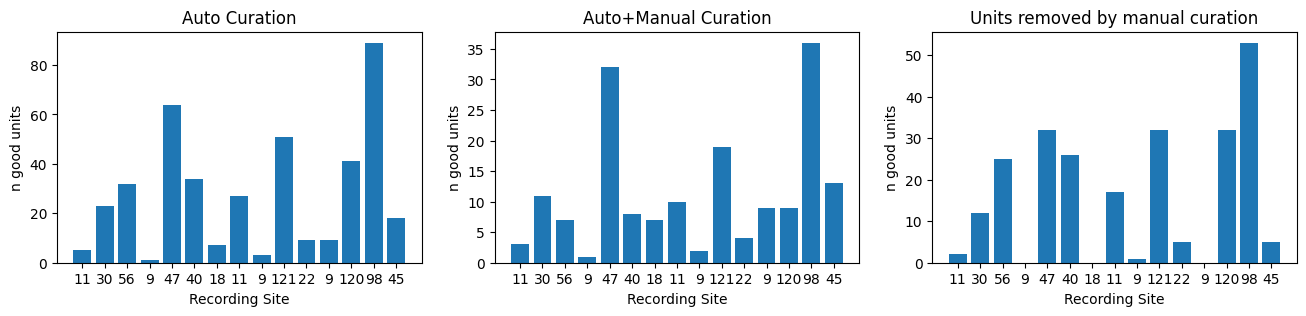

In [32]:
fig, ax = plt.subplots(1,3,figsize=(16,3))
ax[0].bar(np.arange(nrecs), [len(quality_metrics['final_good_unit_idx'][irec]) for irec in range(nrecs)])
ax[0].set(xlabel='Recording Site', ylabel='n good units', title=f"Auto Curation")
ax[0].set_xticks(np.arange(nrecs), labels=recording_site)

ax[1].bar(np.arange(nrecs), [len(quality_metrics['manual_good_unit_idx'][irec]) for irec in range(nrecs)])
ax[1].set(xlabel='Recording Site', ylabel='n good units', title=f"Auto+Manual Curation")
ax[1].set_xticks(np.arange(nrecs), labels=recording_site)

ax[2].bar(np.arange(nrecs), [len(quality_metrics['final_good_unit_idx'][irec])-len(quality_metrics['manual_good_unit_idx'][irec]) for irec in range(nrecs)])
ax[2].set(xlabel='Recording Site', ylabel='n good units', title=f"Units removed by manual curation")
ax[2].set_xticks(np.arange(nrecs), labels=recording_site)

plt.show()

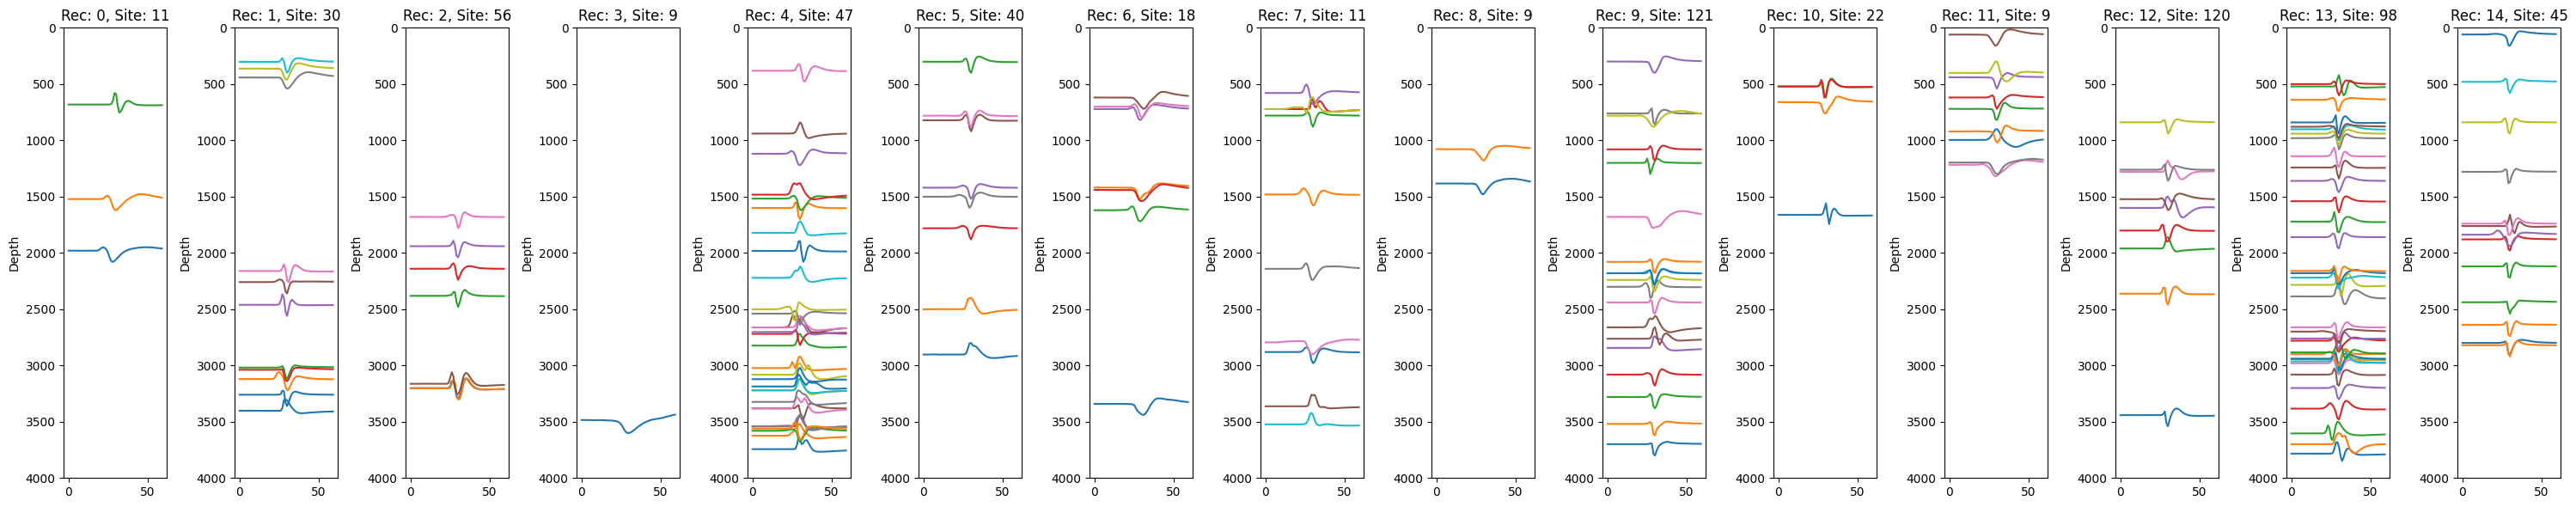

In [33]:
fig, ax = plt.subplots(1,nrecs,figsize=(2*nrecs,6))
for irec in range(nrecs):
    
    for iunit in range(len(quality_metrics['mean_wfs'][irec])):
        if quality_metrics['final_good_unit_labels'][irec][iunit] in quality_metrics['manual_good_unit_labels'][irec]:
            norm_wf = -100*quality_metrics['mean_wfs'][irec][iunit,:]/np.max(np.abs(quality_metrics['mean_wfs'][irec][iunit,:]))
            ax[irec].plot(3840 - quality_metrics['position'][irec][iunit] + norm_wf)
    
    ax[irec].set(title=(f"Rec: {irec}, Site: {recording_site[irec]}"), ylabel='Depth', ylim=(0,4000))
    ax[irec].invert_yaxis()
fig.tight_layout()
plt.show()

# Get pseudopopulation info

In [34]:
ntrials = 400 #
def calc_presence_ratio_pseudopop(data, min_trial_prop=0.95, ntrials=400, return_details=False):
    '''
    This function finds the first ntrials that satisfy the presence ratio criteria

    Args:
        data (ntime, ntrials, nunit):
        min_trial_prop (float): proportion of trials a unit must have a spike on 
        
    Returns:
        present_trials (ntrial_wind, nunit): Trial range that first satisfies the presence ratio criteria. NaN if it is never satisfied
        trial_range_labels (ntrial_wind, 2): Trial numbers that correspond to the rows in 'present_trials'
        presence_details (ntrials, nunit): Optional if 'return_details=True' Identifies which trials each unit is active on 
    '''   
    _, ndata_trials, nunits = data.shape
    nwind = ndata_trials - ntrials
    
    trial_range_labels = np.zeros((nwind,2))*np.nan
    present_trials = np.zeros((nwind, nunits)).astype(bool)
    for iwind in range(nwind):
        start_trial_idx = iwind
        end_trial_idx = iwind+ntrials
        _, present_units, _ = calc_presence_ratio(data[:,start_trial_idx:end_trial_idx,:], min_trial_prop=min_trial_prop)
        
        trial_range_labels[iwind,:] = np.array([start_trial_idx, end_trial_idx])
        present_trials[iwind,:] = present_units
        
    return present_trials, trial_range_labels
        
       


# Save QC results

In [35]:
start = time.time()
if subject == 'beignet':
    aopy.data.base.pkl_write(f"{subject}_QCunits", (quality_metrics, drift), save_dir)
elif subject == 'affi':
    aopy.data.base.pkl_write(f"{subject}_QCunits", (quality_metrics), save_dir)
print(time.time()-start)

0.06077313423156738


In [36]:
start = time.time()
test = aopy.data.base.pkl_read(f"{subject}_QCunits", save_dir)
print(time.time()-start)

0.02323603630065918


In [37]:
print(test.keys())

AttributeError: 'tuple' object has no attribute 'keys'